In [2]:
!pip3 install simpy

amount_donated: 202
amount_used: 167
amount_expired: 33
amount_in_bank: 2


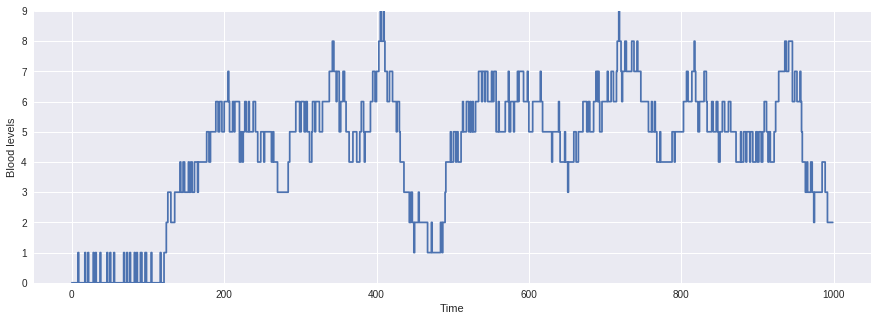

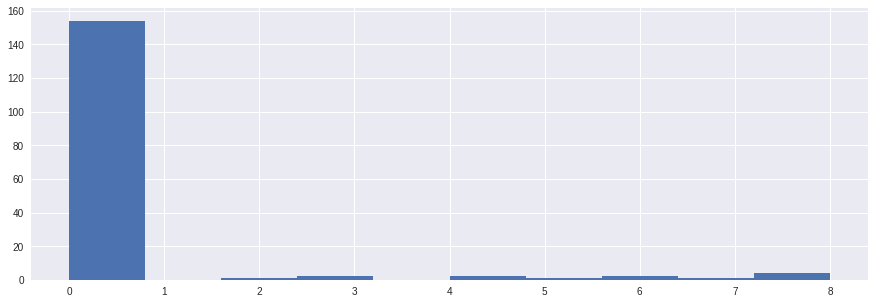

In [3]:
import matplotlib.pylab as plt
from scipy.stats import poisson
import simpy


'''

Blood Bank Simulation

"Donors" put blood bags into the store.
The blood bags are only valid for some time, useless afterwards.
Blood bags are retreived FIFOly by the "Patients" only if they are still valid.
"Patients" are also treated FIFOly (no priority).

'''


SIMULATION_STEPS = 1000
EXPIRATION = 30
PATIENTS_ARRIVAL_DIST = poisson(6)
DONORS_ARRIVAL_DIST = poisson(5)


## Objects
class BloodBag(object):
    ''' Just to set blood bag expiration date '''
    def __init__(self, expiration):
        self.expiration = expiration


## Agents
amount_donated = 0
def donor(env, blood_bags, expiration=EXPIRATION):
    ''' A "donor" puts blood bags into the store '''
    global amount_donated
    blood_bag = BloodBag(expiration=env.now + expiration)
    yield blood_bags.put(blood_bag)
    amount_donated += 1


time_waited = []
amount_received = 0
def patient(env, blood_bags):
    ''' A "patient" gets valid blood bags from the store '''
    global amount_received
    start = env.now
    yield blood_bags.get(lambda x: x.expiration > env.now)
    time_waited.append(env.now - start)
    amount_received += 1


## Generators
def generate_donors(env, blood_bags, expiration=EXPIRATION,
                    dist=DONORS_ARRIVAL_DIST):
    while True:
        env.process(donor(env, blood_bags, expiration))
        yield env.timeout(dist.rvs())


def generate_patients(env, blood_bags,
                      dist=PATIENTS_ARRIVAL_DIST):
    while True:
        env.process(patient(env, blood_bags))
        yield env.timeout(dist.rvs())


obs_time, obs_blood = [], []
def observer(env, blood_bags):
    while True:
        obs_time.append(env.now)
        amount_in_bank = sum([blood_bag.expiration >= env.now
                              for blood_bag in blood_bags.items])
        obs_blood.append(amount_in_bank)
        yield env.timeout(1)


## Environment
env = simpy.Environment()
blood_bags = simpy.FilterStore(env)
env.process(generate_patients(env, blood_bags))
env.process(generate_donors(env, blood_bags))
env.process(observer(env, blood_bags))
env.run(until=SIMULATION_STEPS)


## Monitoring
print('amount_donated: {}'.format(amount_donated))
print('amount_used: {}'.format(amount_received))
amount_in_bank = sum([blood_bag.expiration >= env.now
                      for blood_bag in blood_bags.items])
amount_expired = len(blood_bags.items) - amount_in_bank
print('amount_expired: {}'.format(amount_expired))
print('amount_in_bank: {}'.format(amount_in_bank))

f, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.step(obs_time, obs_blood, where='post')
ax.set_ylabel('Blood levels')
ax.set_ylim([0, max(obs_blood)])
ax.set_xlabel('Time')
plt.show()

f, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.hist(time_waited)
plt.show()